The following files are proccessed:  ['Input\\Labs01.csv', 'Input\\Labs02.csv', 'Input\\Labs03.csv']
Processed 20 patients, and 1217 laboratory values
Writing results to disk


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Done, press enter to exit... 


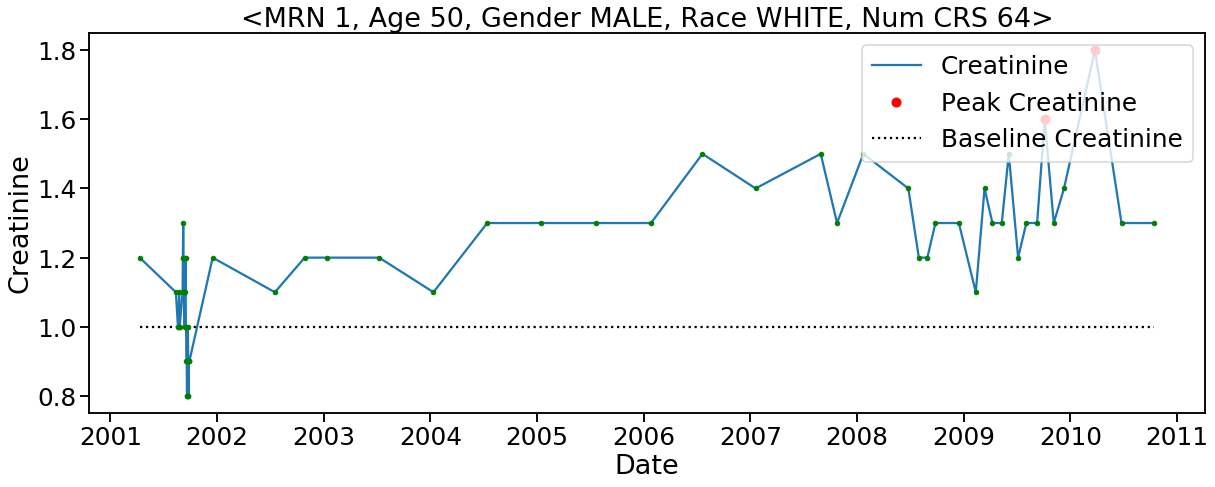

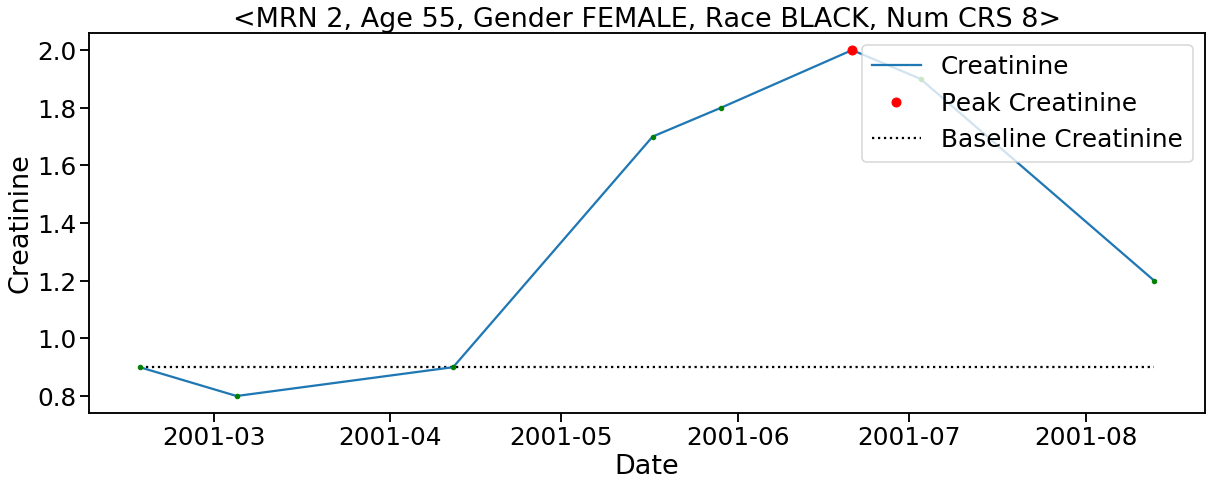

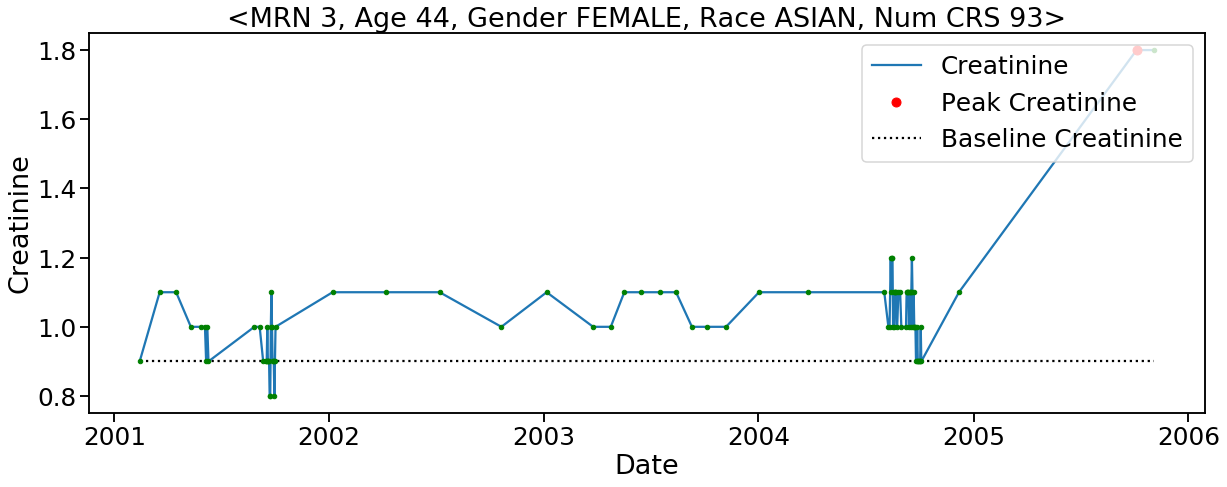

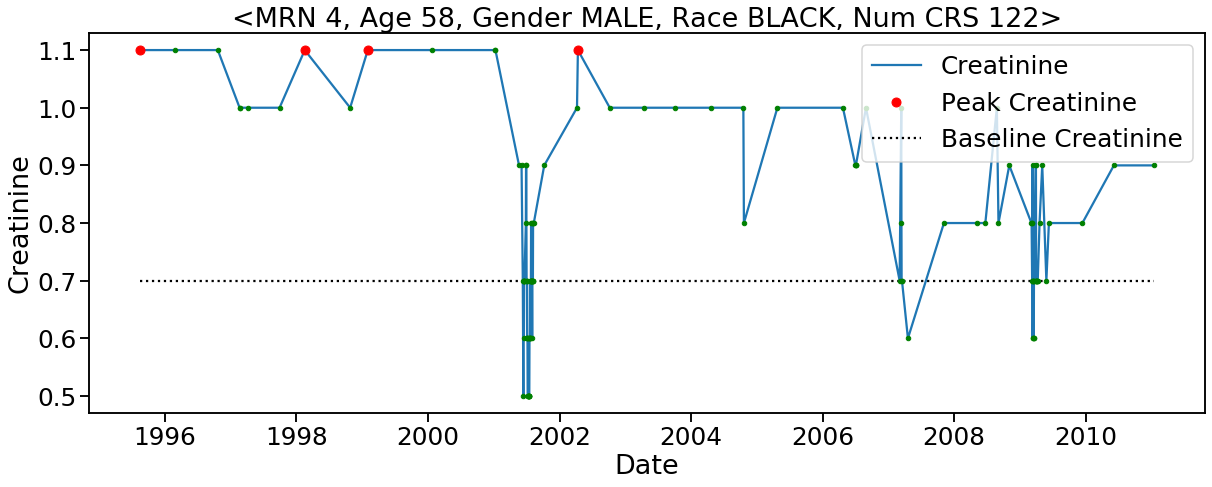

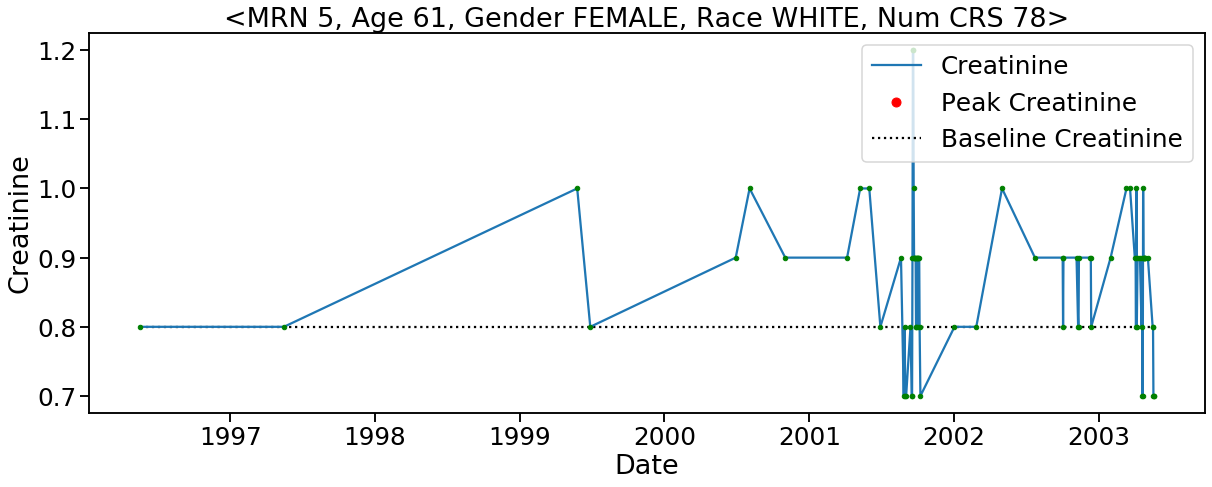

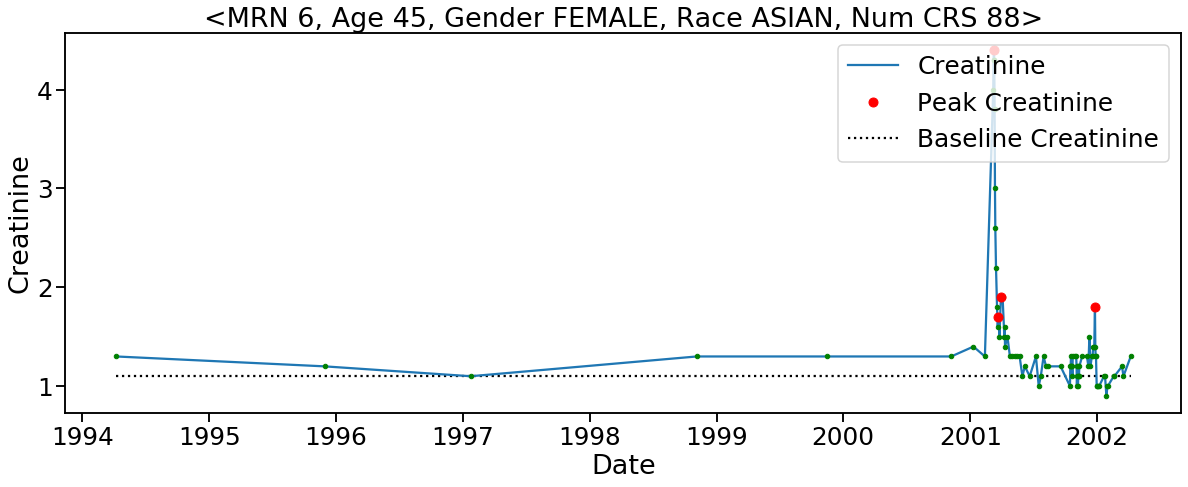

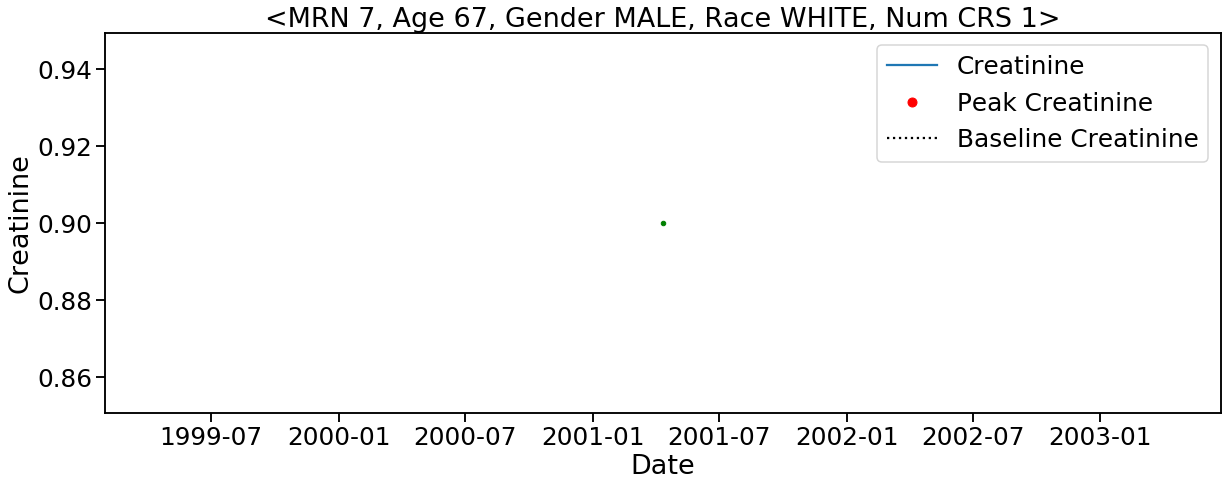

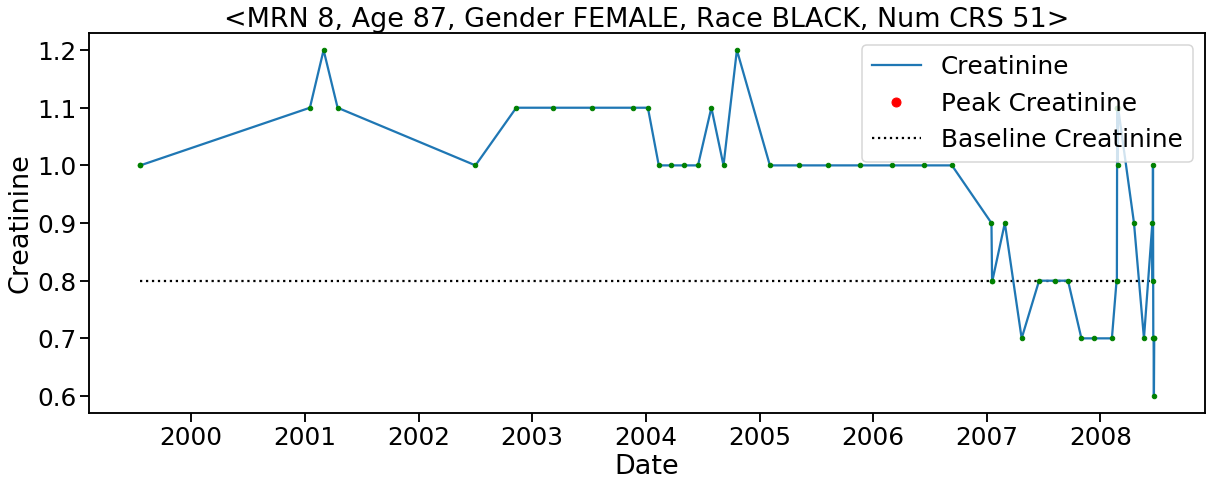

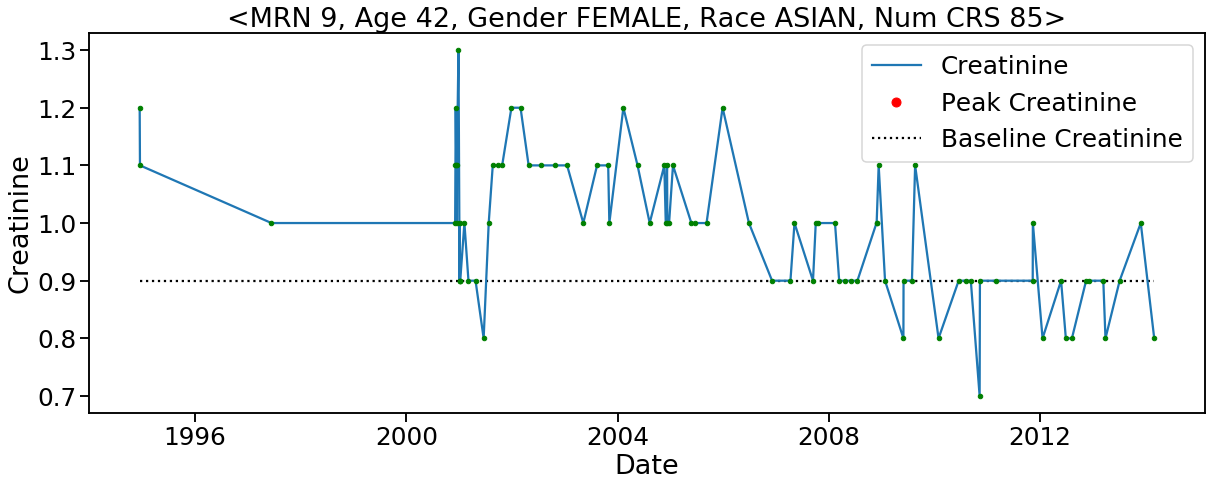

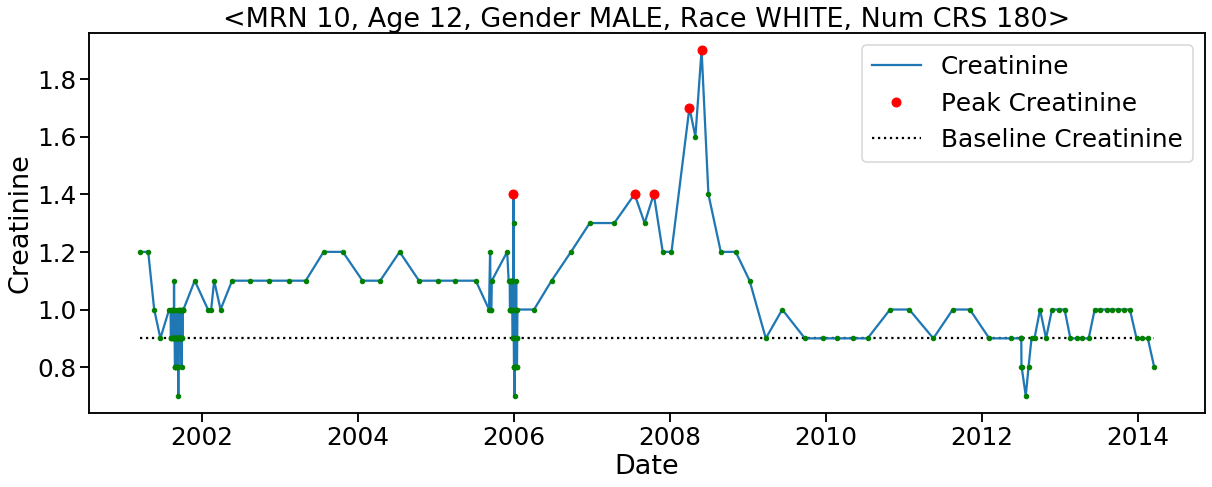

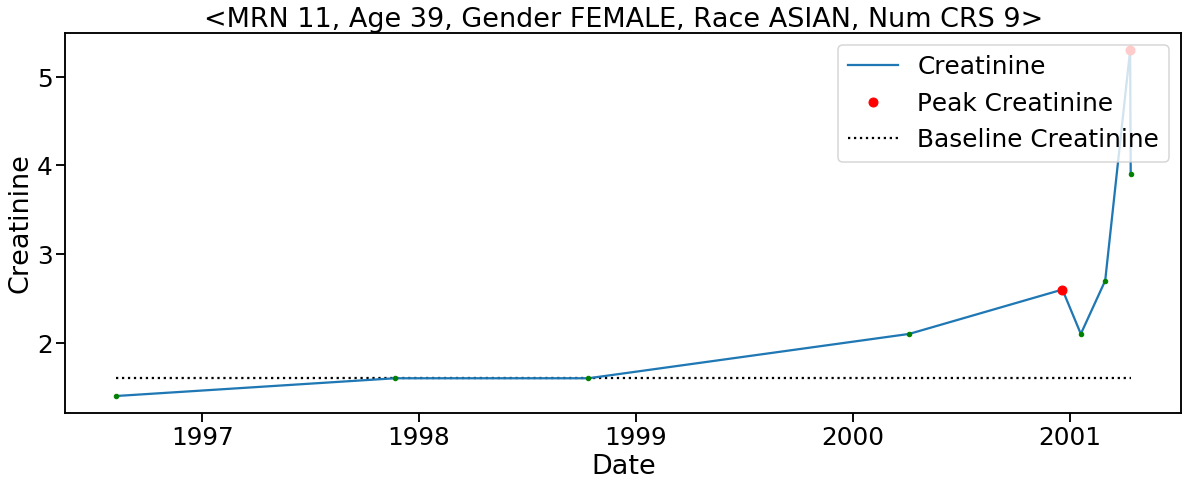

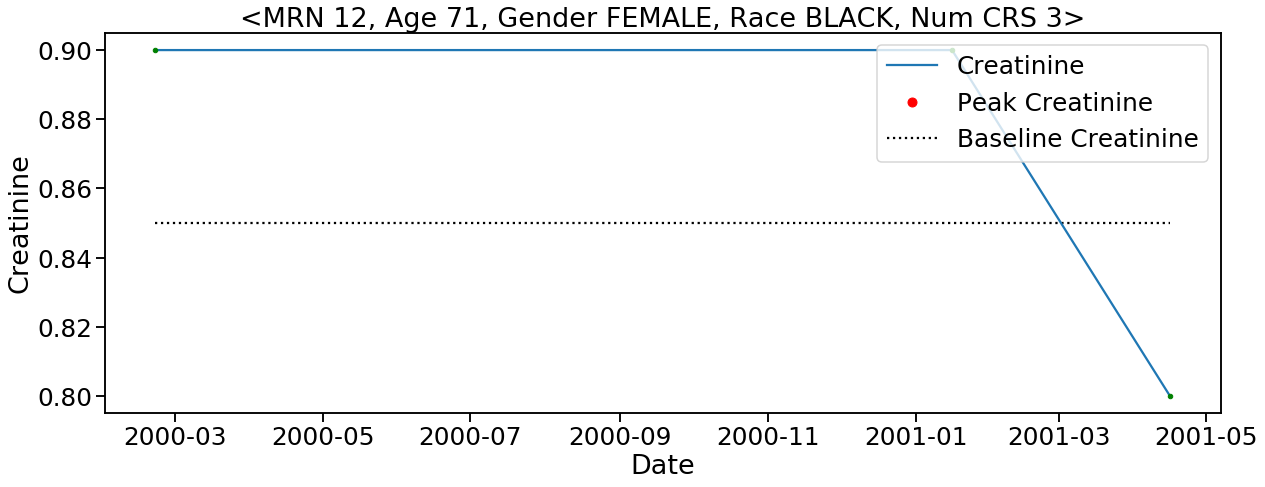

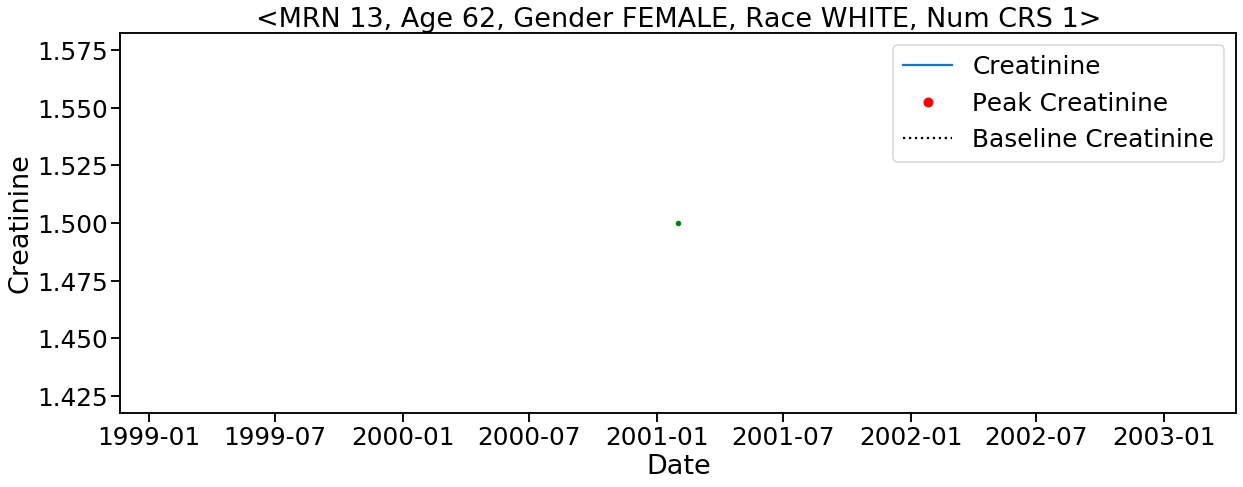

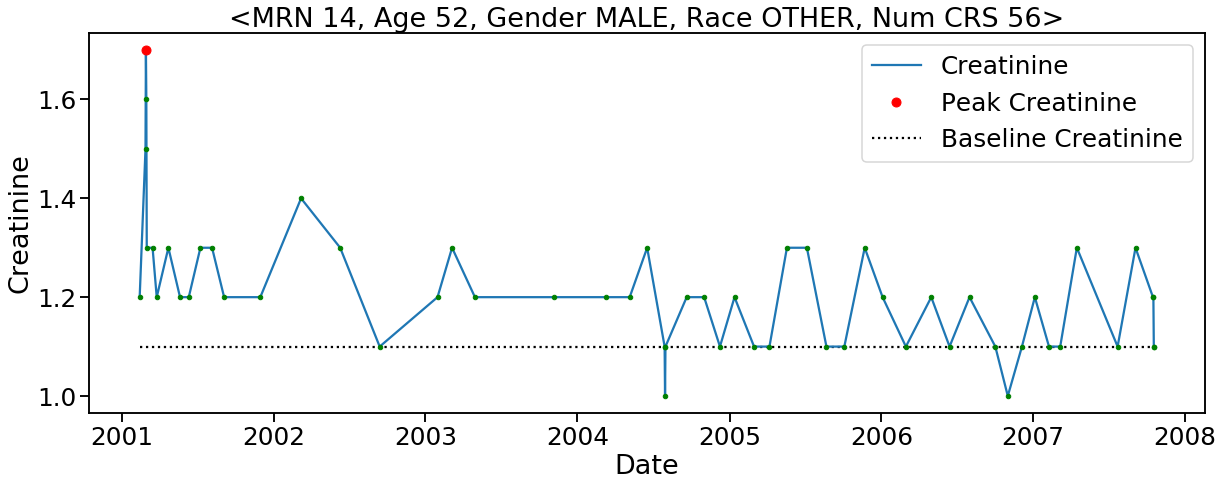

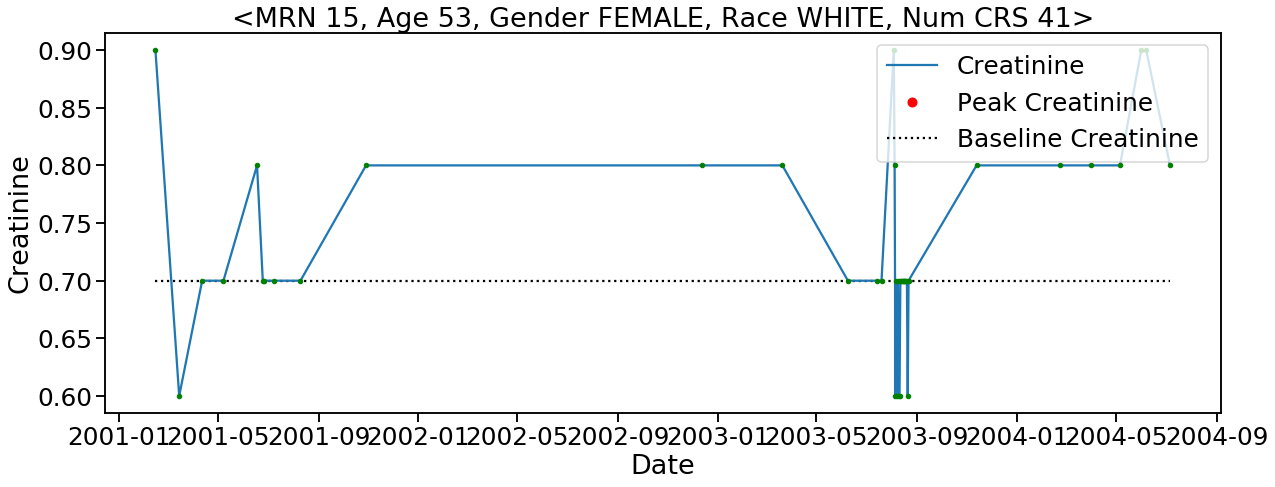

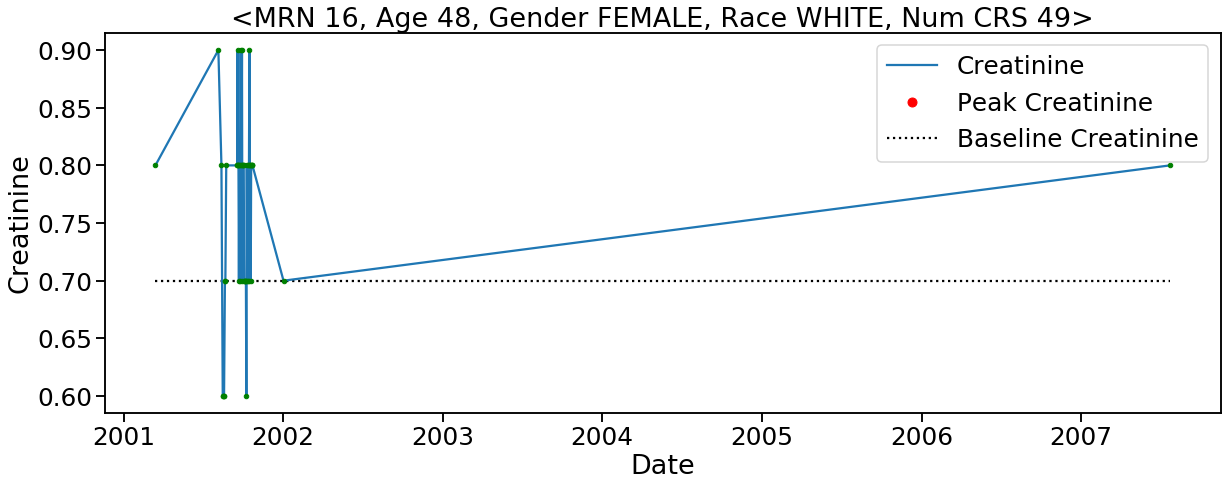

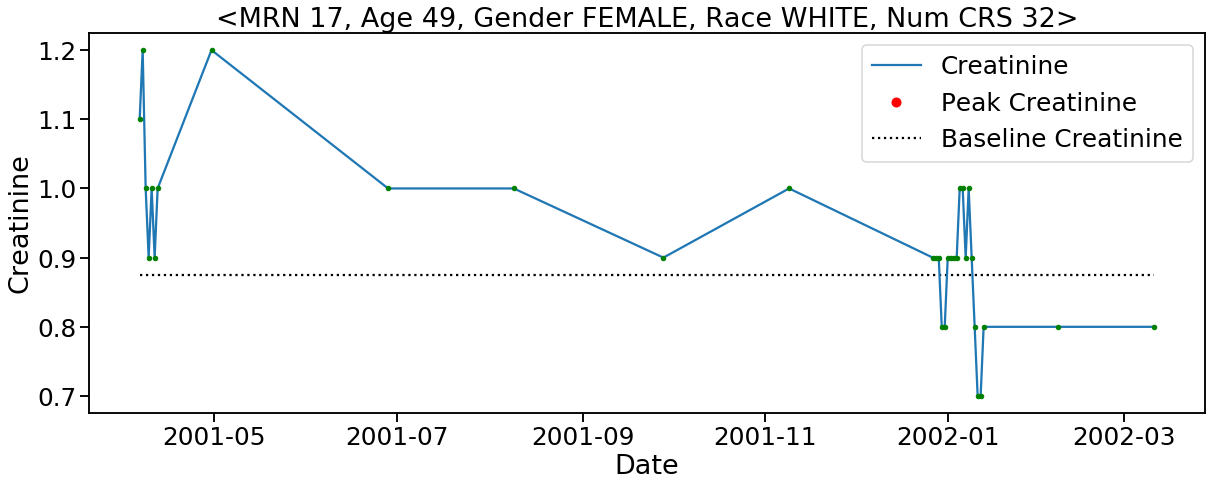

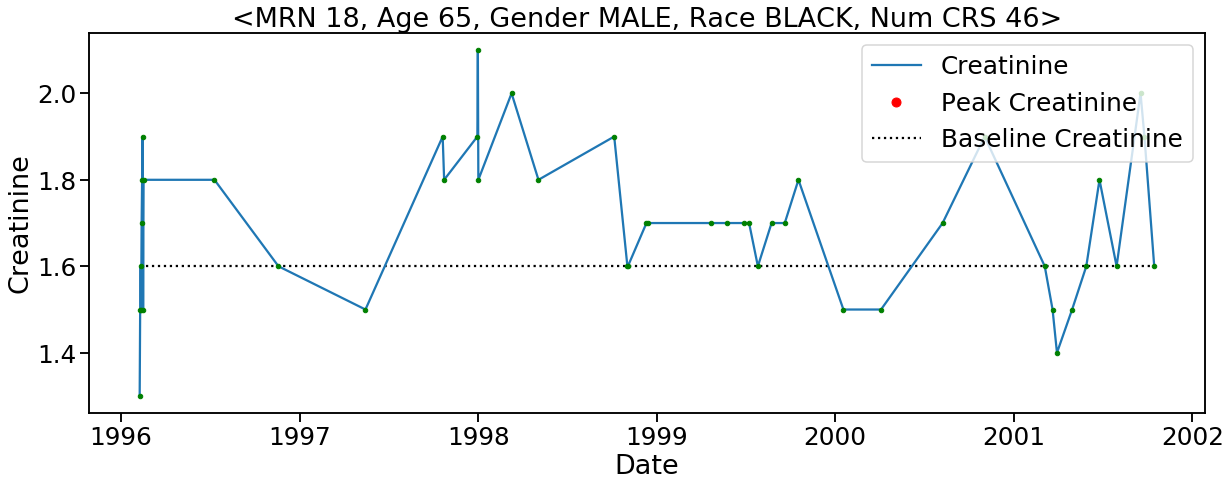

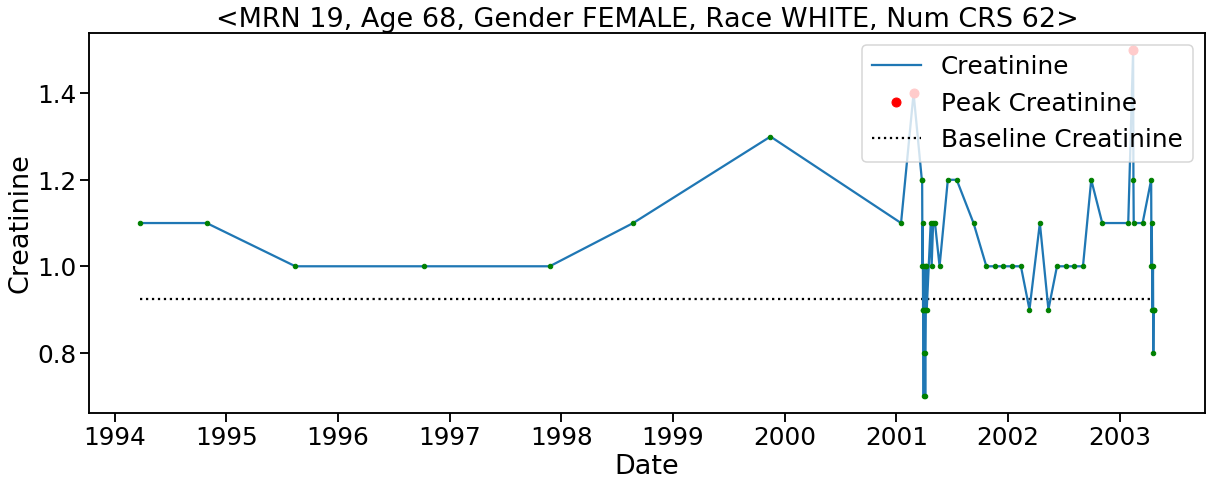

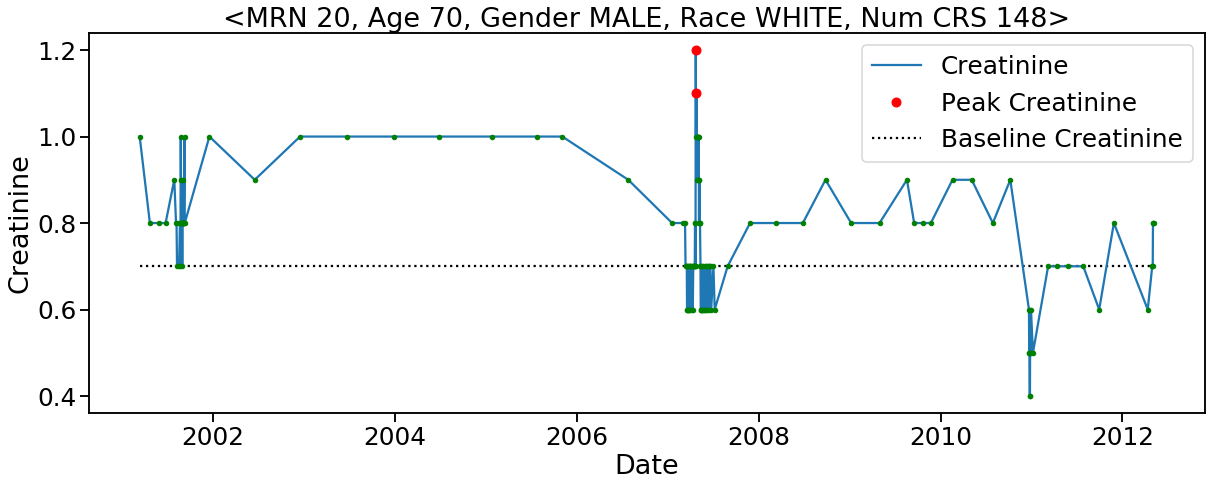

In [3]:
# -*- coding: utf-8 -*-
"""@author: Mohcine Madkour"""

from patient import Patient
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import matplotlib
import seaborn as sns
sns.set_context(context='talk', font_scale=1.5)

matplotlib.rcParams['figure.figsize'] = 20, 7

demDict = pd.DataFrame(columns = ['MRN', 'age', 'gender', 'race'])
ptDict = {} # Dictionary containing all lab values
Patients = {} # Dictonary, keys are MRN, values are Patient objects
        
def getNumPatients():
    return len(Patients)
    
def getNumCrs():
    return sum([Patients[p].crs.size for p in Patients])

def stageCKD(egfr):
    if egfr < 15: return 5
    elif egfr >= 15 and egfr < 30: return 4
    elif egfr >= 30 and egfr < 60: return 3
    elif egfr >= 60 and egfr < 90: return 2
    else: return np.NaN
     
def createPtDict(df: pd.DataFrame):
    global ptDict 
    uniqueMRN = np.unique(df.iloc[:, 0])
    for i in uniqueMRN: 
        if not(i in ptDict.keys()): ptDict[i] = dict()
    for i in range(len(df)):
        mrn = df.iloc[i, 0]
        creatinine = df.iloc[i, 1]
        date = df.iloc[i, 2]
        if not(np.isnan(mrn) or np.isnan(creatinine)): 
            ptDict[int(mrn)][str(date)] = float(creatinine)
    return ptDict

def createPts(patients: dict):
    global Patients
    for key in patients:
        crs = patients[key]
        mrn = key
        age, gender, race = 0, 0, 0
        if any(demDict.MRN == key):
            index = demDict.index[demDict.MRN == key][0]
            age = demDict.Age[index]
            gender = demDict.Gender[index]
            race = demDict.Race[index]
        if len(crs) > 0: Patients[mrn] = Patient(mrn, crs, age, gender, race)

def getPlots(keys: list, savetofile = False):
    global Patients
    for key in keys:
        p = Patients[key]
        p.data.sort_index(inplace=True)
        plt.figure()
        p.plot()
        if savetofile: 
            outputfile = "Output/Graphs/" + str(key) + ".png"
            plt.savefig(outputfile,bbox_inches='tight')
        else: plt.show()

def getDetailedTables(keys: list, savetofile = False):
    global Patients
    for key in keys:
        akiDates = Patients[key].aki
        if savetofile:
            outputfile = "Output/Dates/" + str(key) + ".csv"
            if akiDates.size > 0: akiDates.to_csv(outputfile)
        else:
            print(akiDates)
    return akiDates

def getMasterTable(keys: list, savetofile = False):
    global Patients
    mrn, aki, baseCr, egfr = [], [], [], []
    for key in keys:
        mrn.append(Patients[key].mrn)
        aki.append(Patients[key].aki.size)
        baseCr.append(Patients[key].baseCr)
        egfr.append(Patients[key].egfr)
    di = {'MRN': mrn, 'baseCr': baseCr, 'numAKI': aki, 'eGFR' : egfr}
    df = pd.DataFrame(di)
    df['anyAKI'] = df.numAKI > 0
    df['CKD'] = [stageCKD(i) for i in df.eGFR]
    outputfile = "Output/aki.csv"
    if savetofile: df.to_csv(outputfile, index = False)
    else: print(df)
    return df

def readDemographics(file: str):
    global demDict
    demDict = pd.read_csv(file)
        
def readLabs(files:[str]):
    for file in files: 
        createPtDict(pd.read_csv(file))
    createPts(ptDict)
    
def write():
    global Patients
    getMasterTable(Patients.keys(), savetofile = True)
    getDetailedTables(Patients.keys(), savetofile = True)
    getPlots(Patients.keys(), savetofile = True)
    
if __name__ == "__main__":
    demographicsFile = "Input/Demographics.csv"
    try: readDemographics(demographicsFile)
    except: print("Demographics.csv was not found, proceeding without eGFR calculation") 
    
    labFiles = glob.glob("Input/Labs*.csv")
    print("The following files are proccessed: ", labFiles)
    readLabs(labFiles)
    
    message = "Processed {} patients, and {} laboratory values"\
        .format(getNumPatients(), getNumCrs(),)
    print(message)
    print("Writing results to disk")    
    write()
    input("Done, press enter to exit...")
